In [1]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# solution for relative imports in case realseries is not installed
sys.path.append('/home/cuipeng/realseries')
import argparse
from realseries.models.base_rnn import rnn_base
from realseries.models.hnn import HNN
from realseries.utils.data import load_exp_data

In [3]:
data_name = 'air_quality'
fractions= [0.6,0.2,0.2]
window_size = 7
prediction_window_size = 1


In [4]:
data_dir = os.path.join('../examples/exp_data/')
data_path = data_dir + data_name + '.csv'
data = pd.read_csv(data_path)
data.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NO2(GT),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),RH,AH,NOx(GT)
0,2.7,1280.0,9.6,964.0,113.0,963.0,1544.0,1285.0,64.1,0.7597,193.0
1,1.9,1196.0,7.4,873.0,97.0,1071.0,1463.0,1144.0,63.9,0.7423,139.0
2,1.6,1184.0,5.4,782.0,82.0,1176.0,1365.0,1043.0,63.9,0.7256,83.0
3,1.7,1172.0,5.4,783.0,109.0,1179.0,1380.0,996.0,67.5,0.7173,180.0
4,1.8,1147.0,6.2,821.0,83.0,1132.0,1412.0,992.0,71.1,0.7158,109.0


In [5]:
# load raw data and get train data, validation data and test data
train_data, train_label, test_data, test_label, val_data, val_label, sc = load_exp_data(data_name, window_size, prediction_window_size, fractions)


load data from /home/cuipeng/realseries/realseries/utils/../../examples/exp_data/air_quality.csv


In [61]:
print(train_data.shape,train_label.shape)

(5577, 7, 11) (5577, 1)


Text(0.5, 0.98, 'scaling train label')

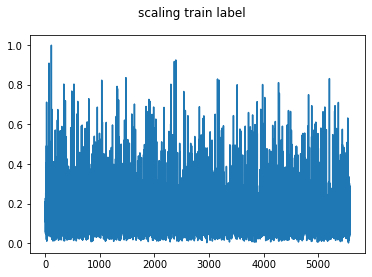

In [62]:
plt.figure()
plt.plot(train_label)
plt.suptitle('scaling train label')

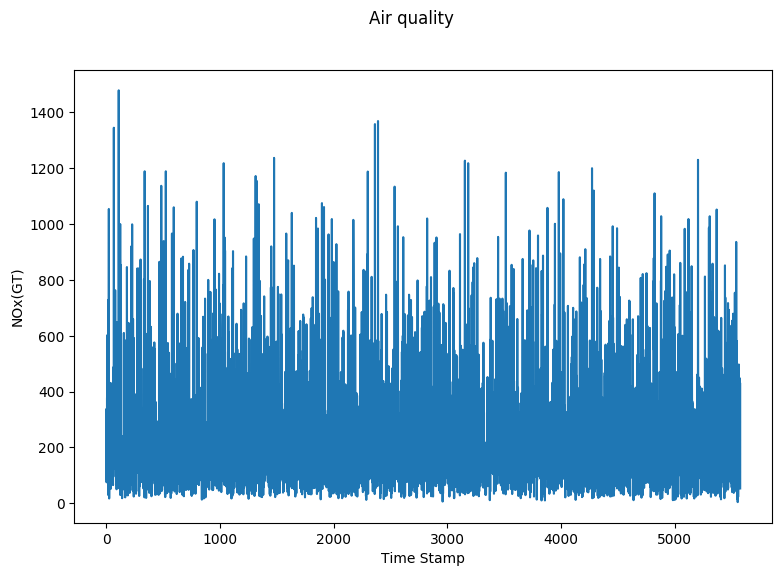

In [9]:
inversed = sc.inverse_transform(np.concatenate((train_data.reshape(train_data.shape[0],-1),train_label),1))
train_label_raw = inversed[:,-train_label.shape[1]:]
plt.figure(figsize=(9,6),dpi=100)
plt.plot(train_label_raw)
plt.suptitle('Air quality')
plt.xlabel('Time Stamp')
plt.ylabel('NOx(GT)')

In [7]:
# start building the HNN model
kernel_type ='LSTM'
activation ='tanh'
dropout_rate = 0.3
hiddens = [128,32]
my_hnn = HNN(kernel_type, train_data.shape[-1], hiddens, prediction_window_size, activation, dropout_rate, epochs=1000)

In [65]:
# next to fit the model
my_hnn.fit(train_data, train_label, val_data, val_label,verbose=False)


epoch: 20 -> train_loss: -1262.59314, valid_loss: -1263.74335
epoch: 40 -> train_loss: -1426.55032, valid_loss: -1390.09302
epoch: 60 -> train_loss: -1612.45035, valid_loss: -1595.55389
epoch: 80 -> train_loss: -1803.37010, valid_loss: -1798.59094
epoch: 100 -> train_loss: -1950.28191, valid_loss: -1937.37640
epoch: 120 -> train_loss: -2041.03137, valid_loss: -2016.73206
epoch: 140 -> train_loss: -2066.97670, valid_loss: -2055.80420
epoch: 160 -> train_loss: -2144.00315, valid_loss: -2123.74310
epoch: 180 -> train_loss: -2174.74650, valid_loss: -2166.56970
epoch: 200 -> train_loss: -2206.71918, valid_loss: -2177.00269
saving the model to model/checkpoint200.pt
epoch: 220 -> train_loss: -2234.27763, valid_loss: -2226.11725
epoch: 240 -> train_loss: -2248.44202, valid_loss: -2233.05365
epoch: 260 -> train_loss: -2279.73478, valid_loss: -2275.12939
epoch: 280 -> train_loss: -2293.26937, valid_loss: -2275.14270
epoch: 300 -> train_loss: -2310.80330, valid_loss: -2293.80286
epoch: 320 -> tr

In [66]:
# save the trained model
my_hnn.save_model()

saving the model to model/checkpoint.pt


In [8]:
# load the model and forecast
my_hnn.load_model()
confidence = 95
# return the lower bound and the upper bound arrays of the predictive intervals for test data
pi_low, pi_up, rmse, cali_error = my_hnn.evaluation_model(sc, test_data, test_label, t=1, confidence = confidence)
print('rmse:{}, calibration error:{}'.format(rmse, cali_error))



loading model/checkpoint.pt
rmse:82.22220611572266, calibration error:0.005


In [68]:
print(pi_up.shape)

(1859, 1)


In [9]:
inversed = sc.inverse_transform(np.concatenate((test_data.reshape(test_data.shape[0],-1),test_label),1))
test_label_raw = inversed[:,-test_label.shape[1]:]

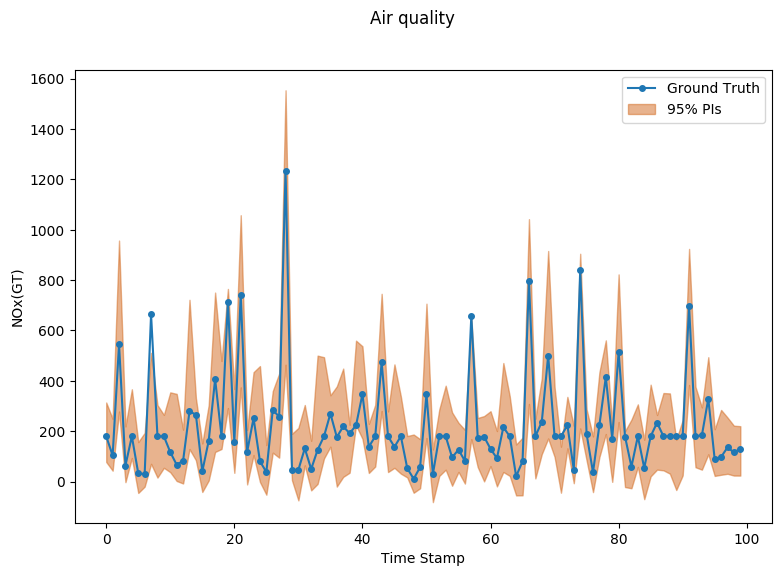

In [10]:

x_temp = [_ for _ in range(100)]
pi_low, pi_up = pi_low.reshape(pi_low.shape[0],), pi_up.reshape(pi_up.shape[0],)
plt.figure(figsize=(9,6),dpi=100)
plt.plot(test_label_raw[0:100], marker='o',ms = 4, lw=1.5, label = 'Ground Truth')
plt.fill_between(x_temp, pi_low[0:100], pi_up[0:100],label = "95% PIs", alpha=0.5, color='#D2691E')
plt.suptitle('Air quality')
plt.xlabel('Time Stamp')
plt.ylabel('NOx(GT)')
plt.legend(loc = 'best')